# Stream Learning applied to 3W dataset

For more information about the theory behind this dataset, refer to the paper **A Realistic and Public Dataset with Rare Undesirable Real Events in Oil Wells** published in the **Journal of Petroleum Science and Engineering** (link [here](https://doi.org/10.1016/j.petrol.2019.106223)).

# 1. Introduction

This Jupyter Notebook fits the 3W dataset to models of the River package on the following scheme:  
  

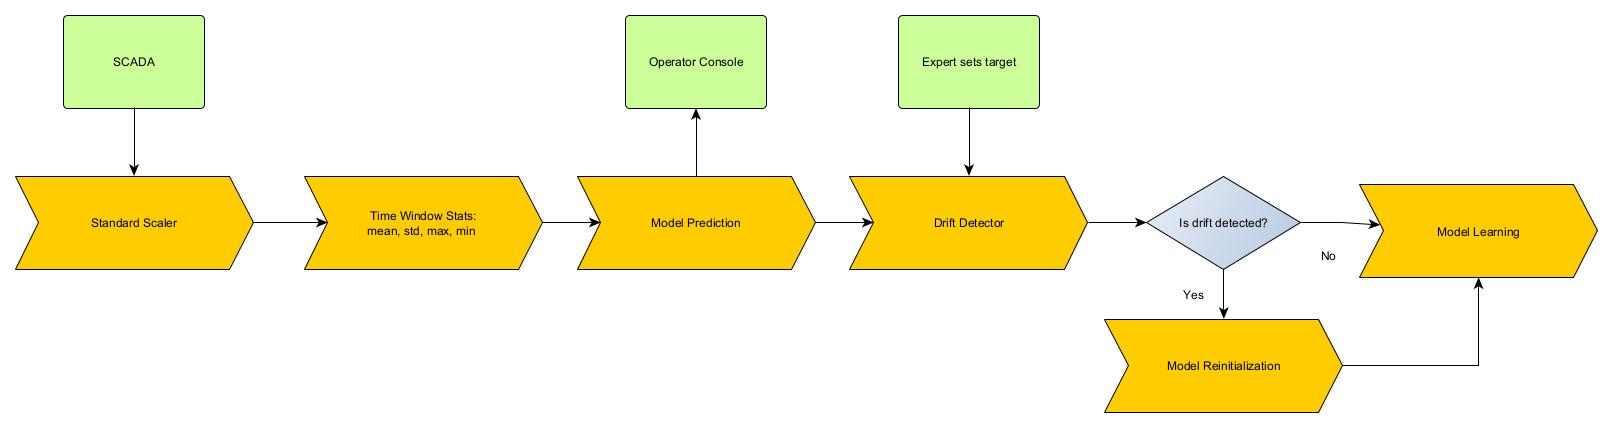

# 2. Imports and Configurations

In [11]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib
import pickle
import graphviz
import river
from copy import deepcopy

from river import stream, feature_extraction as fx, compose, stats, preprocessing, tree, metrics, evaluate
from river import linear_model, optim, drift, anomaly, utils, ensemble, multiclass, datasets, time_series
from river import imblearn, dummy

import sklearn.model_selection
from sklearn.preprocessing import StandardScaler

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [12]:
river.__version__

'0.14.0'

# 3. Instances' Structure

Below, all 3W dataset's instances are loaded and the first one of each knowledge source (real, simulated and hand-drawn) is partially displayed.

In [13]:
class d3w():
    '''
    Class for managing Petrobras 3W dataset
    '''
    def __init__(self, path3w):
        self.path3w = path3w
        self.df = self.__load_df()
        return

    def __load_df(self):

        d = dict()
        d['origin'] = []
        d['well'] = []
        d['ts'] = []
        d['label'] = []
        d['path'] = []
        d['nlines'] = []
        for i in pathlib.Path(self.path3w).iterdir():
            if i.stem.isnumeric():
                print(i)
                label = int(i.stem)
                for fp in i.iterdir():
                    # Considers only csv files
                    if fp.suffix == ".csv":
                        d['well'].append(None)
                        d['ts'].append(None)
                        if (fp.stem.startswith("SIMULATED")):
                            d['origin'].append('S')
                        elif fp.stem.startswith("DRAWN"):
                            d['origin'].append('D')
                        else:
                            d['origin'].append('R')
                            if fp.stem.startswith('WELL'):
                                s = fp.stem
                                d['well'][-1] = int(s[5:10])
                                d['ts'][-1] = pd.Timestamp(year=int(s[11:15]), month=int(s[15:17]), day=int(s[17:19]), 
                                                           hour=int(s[19:21]), minute=int(s[21:23]), second=int(s[23:25]))
                        d['label'].append(label)
                        d['path'].append(fp)
                        d['nlines'].append(self.file_len(fp)-1)
                        
        return pd.DataFrame(d)
    
    def split(self, real=True, simul=True, drawn=True, well=None, label=None, test_size=0.2, val_size=0.1, sample_n=None):
        
        tmp0_df = self.get_df(real, simul, drawn, well, label)
        
        if sample_n is not None:
            N = len(tmp0_df.index)
            if N > sample_n:
                ds_list = []
                for i, ni in tmp0_df.groupby('label').count().nlines.items():
                    ns = ni*sample_n//N
                    ds_list.append(tmp0_df[tmp0_df.label == i].sample(n=ns, random_state=200560))
                tmp0_df = pd.concat(ds_list)            
        
        tmp_df, test_df = sklearn.model_selection.train_test_split(tmp0_df, 
                                                        test_size=test_size, 
                                                        random_state=200560, 
                                                        shuffle=True, 
                                                        stratify=tmp0_df['label'])
        
        if val_size == 0:
            print('Instances Train: {}  Test: {}'.format(len(tmp_df.index), 
                                                         len(test_df.index)))
            return tmp_df.reset_index(drop=True),\
                   test_df.reset_index(drop=True)
        
        train_df, val_df = sklearn.model_selection.train_test_split(tmp_df, test_size=val_size, 
                                                        random_state=200560, 
                                                        shuffle=True, 
                                                        stratify=tmp_df['label'])
        print('Instances Train: {}  Test: {}  Validation: {}'.format(len(train_df.index), 
                                                                     len(test_df.index), 
                                                                     len(val_df.index)))
        
        return train_df.reset_index(drop=True),\
               test_df.reset_index(drop=True),\
               val_df.reset_index(drop=True)
    
    def file_len(self, filename):
        j = 0
        with open(filename) as f:
            for i, x in enumerate(f):
                if x.strip() == '':
                    j += 1
        return i + 1 - j
    
    def get_df(self, real=True, simul=True, drawn=True, well=None, label=None):

        if label is not None:
            if not isinstance(label, list):
                label = [label]
            return self.df[self.df.label.isin(label)].drop(columns=['origin', 'well']).reset_index(drop=True)
            
        if well is not None:
            return self.df[self.df['well']==well].drop(columns=['origin', 'well']).reset_index(drop=True)
        
        sel = []
        if real:
            sel.append('R')
        if simul:
            sel.append('S')
        if drawn:
            sel.append('D')
        if sel:
            return self.df[self.df['origin'].isin(sel)].drop(columns=['origin', 'well']).reset_index(drop=True)
    
    @property
    def all(self):
        return self.df.drop(columns=['origin'])
    @property
    def real(self):
        return self.df[self.df['origin']=='R'].drop(columns=['origin']).reset_index(drop=True)
    @property
    def simul(self):
        return self.df[self.df['origin']=='S'].drop(columns=['origin']).reset_index(drop=True)
    @property
    def drawn(self):
        return self.df[self.df['origin']=='D'].drop(columns=['origin']).reset_index(drop=True)


In [14]:
if pathlib.Path('dset_tfm1.pkl').exists():
  with open('dset_tfm1.pkl', 'rb') as f:
    dset = pickle.load(f)
else:
    dset = d3w('../dataset')
    with open('dset_tfm1.pkl', 'wb') as f:
      pickle.dump(dset, f)

Subset for labels 0 (Normal conditions) and 4 (FLOW INSTABILITY) ordered by date.

In [15]:
dset.get_df(real=True, simul=False, drawn=False).groupby('label').count()

,ts,path,nlines
label,,,
0,597,597,597
1,5,5,5
2,22,22,22
3,32,32,32
4,344,344,344
5,12,12,12
6,6,6,6
7,4,4,4


,ts,label,path,nlines
8,2013-12-11 23:00:15,0,..\dataset\0\WELL-00002_20131211230015.csv,7186
9,2013-12-12 01:01:48,0,..\dataset\0\WELL-00002_20131212010148.csv,7093
10,2013-12-12 03:00:00,0,..\dataset\0\WELL-00002_20131212030000.csv,7154
11,2013-12-12 05:00:00,0,..\dataset\0\WELL-00002_20131212050000.csv,7175
12,2013-12-12 07:00:05,0,..\dataset\0\WELL-00002_20131212070005.csv,7154


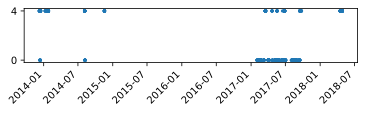

In [16]:
flist = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'T-JUS-CKGL', 'QGL']
categories=[0, 4]

data_df = dset.get_df(real=True, simul=False, drawn=False)
# data_df = data_df.sample(frac=1, random_state=200560).reset_index(drop=True)
data_df = data_df[data_df.label.isin([0, 4])]
data_df = data_df.sort_values('ts').reset_index(drop=True)
plt.figure(figsize=(6, 1))
y = data_df.sort_values(['label', 'ts']).label
x = data_df.sort_values(['label', 'ts']).ts
plt.scatter(x=x, y=y.apply(str), s=5)
plt.xticks(rotation = 45, ha="right")
display(data_df[data_df.label==0][:5])
plt.show()

Each instance is stored in a CSV file and loaded into a pandas DataFrame. Each observation is stored in a line in the CSV file and loaded as a line in the pandas DataFrame. The first line of each CSV file contains a header with column identifiers. Each column of CSV files stores the following type of information:

* **timestamp**: observations timestamps loaded into pandas DataFrame as its index;
* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG);
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT);
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP);
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;
* **class**: observations labels associated with three types of periods (normal, fault transient, and faulty steady state).

Other information are also loaded into each pandas Dataframe:

* **label**: instance label (event type);
* **well**: well name. Hand-drawn and simulated instances have fixed names. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp.  

            TYPE OF UNDESIRABLE EVENT       WINDOW SIZE   
		
            1 - ABRUPT INCREASE OF BSW       12h 
            2 – SPURIOUS CLOSURE OF DHSV     5min–20min 
            3 – SEVERE SLUGGING         	 5h 
            4 – FLOW INSTABILITY             15min 
            5 – RAPID PRODUCTIVITY LOSS 	 12h 
            6 – QUICK RESTRICTION IN PCK     15min 
            7 – SCALING IN PCK               72h 
            8 – HYDRATE IN PRODUCTION LINE   30min–5h 


In [17]:
class CustomGen():
    '''instance generator for the 3W files in dset'''
    
    def __init__(self, dset, flist, target, scaleb=False, out_time=False, ifileb=False, min_std=None):
        self.dset = dset
        self.flist = flist
        self.target = target
        self.scaleb = scaleb
        self.out_time = out_time
        self.ifileb = ifileb
        self.nfiles = len(dset.index)
        self.min_std = min_std
        return
    
    def todataframe(self):
        ds_list = []
        for ifile, p in enumerate(self.dset['path']):
            dfo = pd.read_csv(p, index_col="timestamp", parse_dates=["timestamp"])
            #dfo = dfo[~dfo.index.duplicated(keep="first")].sort_index()

            if np.any(dfo[self.target].isna()):
                dfo[self.target] = dfo[self.target].fillna(method='ffill')
            dfo[self.target] = dfo[self.target].astype(int) #.apply(str)

            flist_ok = []
            flist_na = []
            for f in self.flist:
                nas = np.sum(dfo[f].isna())
                if nas > 0:
                    if nas < len(dfo.index) * 0.2:
                        dfo[f] = dfo[f].fillna(method='ffill')
                        flist_ok.append(f)
                    else:
                        flist_na.append(f)
                else:
                    flist_ok.append(f)

            fdict=dict()
            for f in flist_ok:
                fdict[f] = 'mean'

            def mode(series):
                return pd.Series.mode(series)[0]

            fdict[self.target] = [mode]

            dfo.reset_index(inplace=True)
            dfo['minute'] = dfo['timestamp'].dt.floor('Min')
            ds = dfo.groupby('minute').agg(fdict)
            ds.columns = ds.columns.droplevel(level=1)

            for f in flist_na:
                ds[f] = np.nan
            
            ds['ifile'] = ifile
            
            ds_list.append(ds)
        return pd.concat(ds_list, ignore_index=True)
    
    def iter(self, max_n=None):
        n = 0
        for ifile, p in enumerate(self.dset['path']):
            dfo = pd.read_csv(p, index_col="timestamp", parse_dates=["timestamp"])
            #dfo = dfo[~dfo.index.duplicated(keep="first")].sort_index()

            if np.any(dfo[self.target].isna()):
                dfo[self.target] = dfo[self.target].fillna(method='ffill')
            dfo[self.target] = dfo[self.target].astype(int) #.apply(str)

            flist_ok = []
            flist_na = []
            for f in self.flist:
                nas = np.sum(dfo[f].isna())
                if nas > 0:
                    if nas < len(dfo.index) * 0.2:
                        dfo[f] = dfo[f].fillna(method='ffill')
                        flist_ok.append(f)
                    else:
                        flist_na.append(f)
                else:
                    flist_ok.append(f)

            fdict=dict()
            for f in flist_ok:
                fdict[f] = 'mean'

            def mode(series):
                return pd.Series.mode(series)[0]

            fdict[self.target] = [mode]

            dfo.reset_index(inplace=True)
            dfo['minute'] = dfo['timestamp'].dt.floor('Min')
            ds = dfo.groupby('minute').agg(fdict)
            ds.columns = ds.columns.droplevel(level=1)

            for f in flist_na:
                ds[f] = np.nan
            
            if self.scaleb:
                np.seterr(divide='ignore', invalid='ignore')
                dfd = self.scale(ds[self.flist]).to_dict(orient='records')
                np.seterr(divide='warn', invalid='warn')
            else:
                dfd = ds[self.flist].to_dict(orient='records')
            for i, x in enumerate(dfd):
                #assert isinstance(df.iloc[i][self.target], np.int32), 'class not an integer!'
                result = []
                if self.ifileb:
                    result.append(ifile)
                if self.out_time:
                    result.append(ds.index[i])
                yield result + [x, ds.iloc[i][self.target]]
                n += 1
                if max_n is not None and n > max_n:
                    break
            if max_n is not None and n > max_n:
                break

        return
    
    def scale(self, df):
        xm = df[self.flist].mean()
        sm = df[self.flist].std()
        if self.min_std is not None:
            sm = pd.concat([sm, pd.Series(self.min_std)]).groupby(level=0).max()[sm.index]
        return (df[self.flist]-xm)/sm

    def plot(self, ifiles):
        
        if isinstance(ifiles, list):
            n_files = len(ifiles)
        else:
            ifiles = [ifiles]
            n_files = 1
        
        fig, axs = plt.subplots(nrows=len(self.flist)+1, ncols=n_files, figsize=(10, 12), sharex='col')
        axs = axs.flatten()

        dss = []
        supt = ''
        for i_col, i_f in enumerate(ifiles):
        
            dss.append(pd.read_csv(self.dset['path'][i_f], parse_dates=["timestamp"]))
            #ds = ds.drop_duplicates(subset='timestamp', keep="last").sort_values(by=['timestamp']).reset_index(drop=True)
            if np.any(dss[i_col][self.target].isna()):
                ds[i_col][self.target] = ds[i_col][self.target].fillna(method='ffill')
            
            supt += str(self.dset['path'][i_f])
            if i_col != n_files-1:
                supt += '\n'
            fig.suptitle(supt)

            for i, vs in enumerate(self.flist):
                axs[i*n_files+i_col].plot(dss[i_col].timestamp[::60], dss[i_col][vs][::60])
                if i_col == 0:
                    axs[i*n_files+i_col].set_ylabel(vs)
        
            id = np.argsort(dss[i_col][self.target])
            t = [dss[i_col].timestamp[i] for i in id][::60]
            y = [str(dss[i_col][self.target][i]) for i in id][::60]
        
            axs[(i+1)*n_files+i_col].scatter(t, y, marker='.')
        
            axs[(i+1)*n_files+i_col].xaxis.set_tick_params(rotation=45)
            
            if i_col == 0:
                axs[(i+1)*n_files+i_col].set_ylabel(self.target)
        
            axs[(i+1)*n_files+i_col].set_xlabel('Date')
            
        
        for ax in axs.flatten():
            ax.grid(visible=True)

        return fig  


In [18]:
gen = CustomGen(data_df, flist, 'class', scaleb=True, out_time=True, ifileb=True)
n = 0
for i, time, x, t in gen.iter():
    if i == 3:
        print(i, time, x, t)
        n += 1
        if n > 3:
            break

3 2013-12-09 05:00:00 {'P-PDG': nan, 'P-TPT': 1.0689456673425932, 'T-TPT': -0.9444546644711171, 'P-MON-CKP': 0.09582108322486568, 'T-JUS-CKP': -0.9958246164193104, 'P-JUS-CKGL': -1.7725572725484982, 'T-JUS-CKGL': nan, 'QGL': nan} 4.0
3 2013-12-09 05:01:00 {'P-PDG': nan, 'P-TPT': 1.201075578119019, 'T-TPT': -1.6301541431155548, 'P-MON-CKP': -2.2361080103006716, 'T-JUS-CKP': -0.9958246164193104, 'P-JUS-CKGL': -1.74203817125606, 'T-JUS-CKGL': nan, 'QGL': nan} 4.0
3 2013-12-09 05:02:00 {'P-PDG': nan, 'P-TPT': -1.6548721236820316, 'T-TPT': -0.7753868667243752, 'P-MON-CKP': -0.43277726953755935, 'T-JUS-CKP': -0.9958246164193104, 'P-JUS-CKGL': -1.7115193301978668, 'T-JUS-CKGL': nan, 'QGL': nan} 4.0
3 2013-12-09 05:03:00 {'P-PDG': nan, 'P-TPT': -2.209251944219409, 'T-TPT': 0.6402673183513238, 'P-MON-CKP': 0.484470007376251, 'T-JUS-CKP': -0.9958246164193104, 'P-JUS-CKGL': -1.6809997084369352, 'T-JUS-CKGL': nan, 'QGL': nan} 4.0


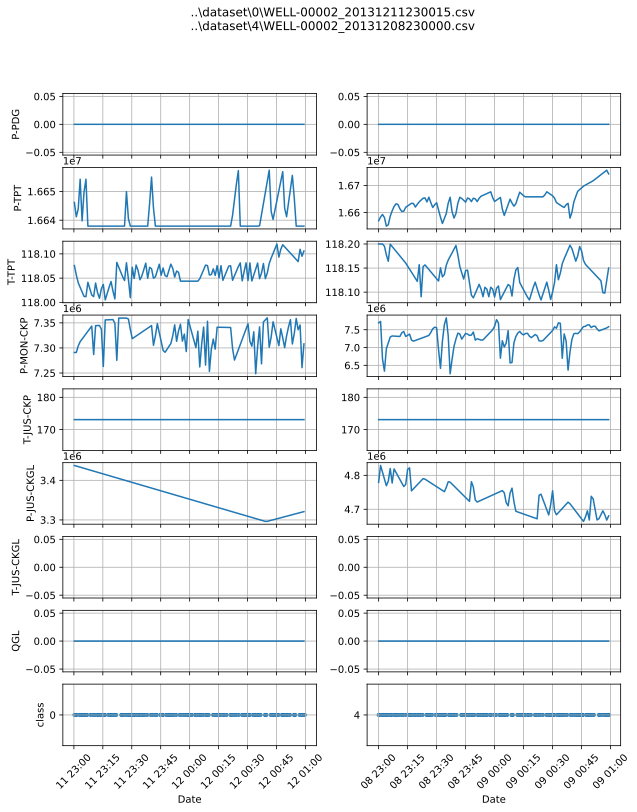

In [19]:
gen.plot([8, 0])
plt.savefig('plot.jpg')

### Ajuste del Modelo  

Fit the subset to River models:
- A time window of 15min is used for calculating the rolling statistics:  
     mean, std, min, max  
  of every feature
- The standard scaler and the rolling statistics are reinitialized every new time series
- The fit starts after a warming period (equal to the rolling window size)

In [20]:
def plot_acc0(i_s, i_sD, accuracies, accuraciesD, first, second):
    plt.figure(figsize=(10,4))

    plt.ylabel('Accuracies')
    plt.plot(i_s, accuracies, label=first)
    plt.plot(i_sD, accuraciesD, label=second)
    plt.legend(loc="lower right")
    plt.title('Accuracies')
    m, M = np.quantile(accuracies, [0.05, 0.95])
    m, M = round(m-0.05, 1), round(M+0.05, 1)    
    m1, M1 = np.quantile(accuraciesD, [0.05, 0.95])
    m1, M1 = round(m1-0.05, 1), round(M1+0.05, 1)    
    plt.ylim([min(m, m1), max(M, M1)])
    plt.grid()
    
    plt.show()
    return

In [21]:
def fit_model(data_df, flist, target, window_size: int, model0, dfB=False, EvalB=False):
    '''Fit data_df 3W files to model0
       flist: features used by the model
       target: target used by the model
    '''
    if EvalB:
        model = model0
    else:
        model = deepcopy(model0)
    dummymodel = dummy.NoChangeClassifier()
    report0 = metrics.ClassificationReport()
    report = metrics.BalancedAccuracy()
    dummyreport = metrics.BalancedAccuracy()
    gen = CustomGen(data_df, flist, target, ifileb=True)
    scaler = preprocessing.StandardScaler()
    window_size = int(window_size)

    def func_reset(flist, window_size):
        fu = dict()
        for f in flist:
            fu[('rmean', f)] = utils.Rolling(stats.Mean(), window_size=window_size)
            fu[('rSEM', f)] = utils.Rolling(stats.SEM(ddof=1), window_size=window_size)
            fu[('rMax', f)] = stats.RollingMax(window_size=window_size)
            fu[('rMin', f)] = stats.RollingMin(window_size=window_size)
        return fu

    ys = []
    y_preds = []
    y_dummies = []
    accuracies = []
    dummyaccuracies = []
    ifiles = []
    i_s = []
    lastfile = -1
    warm_start = window_size
    j = 0
    if dfB:
        df_list = []
    for i, (ifile, x, y) in enumerate(gen.iter(max_n=None)):
        if ifile != lastfile:
            print('\rfiles learned ', ifile+1, '/', gen.nfiles, end='')
            scaler = preprocessing.StandardScaler()
            fu = func_reset(flist, window_size)
            lastfile = ifile
            j = 0
        x = {k: v for k, v in x.items() if not np.isnan(v)}
        x = scaler.learn_one(x).transform_one(x)
        xd = dict()
        for ff, f in fu.keys():
            if f in x.keys():
                xd[f+'_'+ff] = fu[(ff, f)].update(x[f]).get()
        j += 1
        if j >= warm_start:
            y_pred = model.predict_one(xd)
            y_dummy = dummymodel.predict_one(xd)
            if y_pred is None:
                y_pred = 0
                y_dummy = 0
                #print(i, ifile, x, y)
            report0 = report0.update(y, y_pred)
            report = report.update(y, y_pred)
            dummyreport = dummyreport.update(y, y_dummy)

            if not EvalB:
                model.learn_one(xd, y)
                dummymodel.learn_one(xd, y)

            if dfB:
                xd[target] = y
                df_list.append(xd)
            ys.append(y)
            y_preds.append(y_pred)
            y_dummies.append(y_dummy)
            accuracies.append(report.get())
            dummyaccuracies.append(dummyreport.get())
            ifiles.append(ifile)
            i_s.append(i)

    print('\n', report)
    print('\n NoChangeClassifier', dummyreport)
    print('\n', report0)
    if dfB:
        return i_s, ys, y_preds, y_dummies, accuracies, dummyaccuracies, report, dummyreport, ifiles,\
                model, pd.DataFrame(df_list)
    return i_s, ys, y_preds, y_dummies, accuracies, dummyaccuracies, report, dummyreport, ifiles, model

In [22]:
%%time

#model =  tree.HoeffdingTreeClassifier(delta=1.E-4)
#model =  multiclass.OneVsOneClassifier(linear_model.PAClassifier(C=1.0, mode=1))
#model = multiclass.OneVsOneClassifier(linear_model.ALMAClassifier())
Basemodel = imblearn.RandomOverSampler(tree.HoeffdingTreeClassifier(delta=1.E-4),
            desired_dist={0: 0.6, 4: 0.4}, seed=200560)
# model = imblearn.RandomOverSampler(multiclass.OneVsOneClassifier(linear_model.ALMAClassifier(alpha=0.85, B=1./0.85)),
#                                   desired_dist={0: 0.4, 102: 0.2, 2: 0.4}, seed=200560)
model = deepcopy(Basemodel)


flist = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'T-JUS-CKGL', 'QGL']
window_size = 30

i_s, ys, y_preds, y_dummies, accuracies, dummyaccuracies, report, dummyreport, ifiles, model, df =\
                 fit_model(data_df, flist, 'class', window_size, model, dfB=True, EvalB=False)


files learned  941 / 941
 BalancedAccuracy: 92.43%

 NoChangeClassifier BalancedAccuracy: 99.95%

            Precision   Recall   F1       Support  
                                                  
     0.0      97.67%   95.68%   96.67%    149201  
     4.0      81.34%   89.19%   85.08%     31501  
                                                  
   Macro      89.51%   92.43%   90.87%            
   Micro      94.55%   94.55%   94.55%            
Weighted      94.82%   94.55%   94.65%            

                 94.55% accuracy                  
CPU times: total: 3min 27s
Wall time: 3min 45s


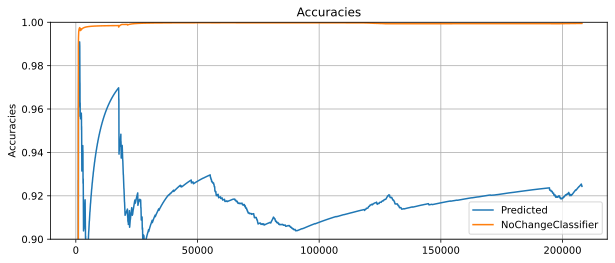

In [23]:
plot_acc0(i_s, i_s, accuracies, dummyaccuracies, 'Predicted', 'NoChangeClassifier')

In [96]:
model.classifier.draw(max_depth=4).render('model', format='jpg', view=False)
pd.DataFrame.from_dict(model.classifier.summary, 'index').transpose()


(dot.exe:17600): Pango-WARNING **: couldn't load font "trebuchet Not-Rotated 11", falling back to "Sans Not-Rotated 11", expect ugly output.


,n_nodes,n_branches,n_leaves,n_active_leaves,n_inactive_leaves,height,total_observed_weight
0,183.0,91.0,92.0,92.0,0.0,12.0,272921.0


In [25]:
from sklearn.metrics import classification_report
#np.unique(y_preds, return_counts=True)
print(classification_report(ys, y_preds))

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97    149201
         4.0       0.81      0.89      0.85     31501

    accuracy                           0.95    180702
   macro avg       0.90      0.92      0.91    180702
weighted avg       0.95      0.95      0.95    180702



In [26]:
%%time

# Variable Importance

from sklearn.ensemble import RandomForestClassifier

f_list = []
for f in df.columns:
    n = sum(df[f].isnull())
    print(f, n)
    if n == 0:
        f_list.append(f)
f_list = f_list[:-1]

forest = RandomForestClassifier(n_estimators=10, class_weight='balanced', random_state=200560)
forest.fit(df[f_list], df['class'])
print('mean accuracy Random Forest: ', forest.score(df[f_list], df['class']))
varImp = {'var': f_list, 'varImp': forest.feature_importances_}
varImp = pd.DataFrame(varImp).sort_values(['varImp'], ascending=False)
print(varImp)

varImp = {'var': [x[0] for x in [x.split('_') for x in f_list]], 'varImp': forest.feature_importances_}
varImp = pd.DataFrame(varImp)
varImp = varImp.groupby('var').sum().sort_values(['varImp'], ascending=False).reset_index()
varImp

P-PDG_rmean 0
P-PDG_rSEM 0
P-PDG_rMax 0
P-PDG_rMin 0
P-TPT_rmean 0
P-TPT_rSEM 0
P-TPT_rMax 0
P-TPT_rMin 0
T-TPT_rmean 0
T-TPT_rSEM 0
T-TPT_rMax 0
T-TPT_rMin 0
P-MON-CKP_rmean 15207
P-MON-CKP_rSEM 15207
P-MON-CKP_rMax 15207
P-MON-CKP_rMin 15207
T-JUS-CKP_rmean 22198
T-JUS-CKP_rSEM 22198
T-JUS-CKP_rMax 22198
T-JUS-CKP_rMin 22198
P-JUS-CKGL_rmean 53419
P-JUS-CKGL_rSEM 53419
P-JUS-CKGL_rMax 53419
P-JUS-CKGL_rMin 53419
QGL_rmean 44739
QGL_rSEM 44739
QGL_rMax 44739
QGL_rMin 44739
class 0
mean accuracy Random Forest:  0.9992418456906952
            var    varImp
5    P-TPT_rSEM  0.154770
6    P-TPT_rMax  0.147005
7    P-TPT_rMin  0.115666
4   P-TPT_rmean  0.092207
11   T-TPT_rMin  0.088158
10   T-TPT_rMax  0.082608
9    T-TPT_rSEM  0.070829
2    P-PDG_rMax  0.065671
8   T-TPT_rmean  0.065248
1    P-PDG_rSEM  0.060255
0   P-PDG_rmean  0.038304
3    P-PDG_rMin  0.019280
CPU times: total: 4.12 s
Wall time: 6.39 s


,var,varImp
0,P-TPT,0.509647
1,T-TPT,0.306843
2,P-PDG,0.183510


In [27]:
# Random Forest on validation set
print(classification_report(df['class'], forest.predict((df[f_list]))))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    149201
         4.0       1.00      1.00      1.00     31501

    accuracy                           1.00    180702
   macro avg       1.00      1.00      1.00    180702
weighted avg       1.00      1.00      1.00    180702



[]

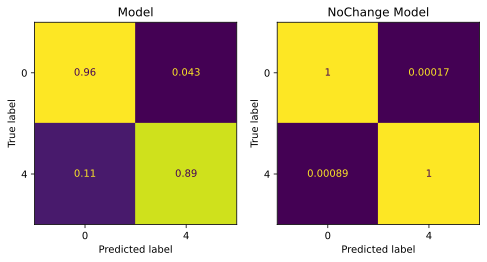

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

_ = ConfusionMatrixDisplay(confusion_matrix(ys, y_preds, labels=categories, normalize='true'), 
                       display_labels=categories).plot(ax=ax[0], colorbar=False)
_ = ConfusionMatrixDisplay(confusion_matrix(ys, y_dummies, labels=categories, normalize='true'), 
                       display_labels=categories).plot(ax=ax[1], colorbar=False)
ax[0].set_title('Model')
ax[1].set_title('NoChange Model')
plt.plot()

## Drift test

In [29]:
def plot_acc(i_s, i_sD, accuracies, accuraciesD, dr, first, second, tit):
    plt.figure(figsize=(10,4))

    plt.ylabel('Accuracies')
    plt.plot(i_s, accuracies, label=first)
    plt.plot(i_sD, accuraciesD, label=second)
    plt.legend(loc="lower right")
    plt.title(tit)
    m, M = np.quantile(accuracies, [0.05, 0.95])
    m, M = round(m-0.05, 1), round(M+0.05, 1)    
    m1, M1 = np.quantile(accuraciesD, [0.05, 0.95])
    m1, M1 = round(m1-0.05, 1), round(M1+0.05, 1)    
    plt.ylim([min(m, m1), max(M, M1)])
#     plt.grid()
    
    res = dr.to_df()
    res0 = res[res.change == True].i.reset_index(drop=True)
    for i in res0:
        plt.axvline(x=i, c='green', alpha=0.25)
    res0 = res[res.new_model == True].i.reset_index(drop=True)
    for i in res0:
        plt.axvline(x=i, c='red')
    plt.show()
    return

In [30]:
class drift_reg:
    def __init__(self):
        self.d = {'i': [], 'n': [], 'ifile': [], 'label': [], 'y': [], 'path': [], 'warn': [], 
                  'change': [], 'new_model': [], 'origin': [], 'well': []}
        return
    def append(self, i, n, ifile, label, y, path, warn, change, new_model):
        self.d['i'].append(i)
        self.d['n'].append(n)
        self.d['ifile'].append(ifile)
        self.d['label'].append(label)
        self.d['y'].append(int(y))
        self.d['path'].append(path)
        self.d['warn'].append(warn)
        self.d['change'].append(change)
        self.d['new_model'].append(new_model)
        self.d['well'].append(None)
        if (path.stem.startswith("SIMULATED")):
            self.d['origin'].append('S')
        elif path.stem.startswith("DRAWN"):
            self.d['origin'].append('D')
        else:
            self.d['origin'].append('R')
            if path.stem.startswith('WELL'):
                self.d['well'][-1] = int(path.stem[5:10])


        return
    def to_df(self):
        return pd.DataFrame(self.d)
    def get_changes(self):
        return sum(self.d['change'])

In [31]:
def fit_modelD(data_df, flist, target, window_size: int, model0, dr, drd0, dfB=False, EvalB=False):
    '''Fit data_df 3W files to model0
       flist: features used by the model
       target: target used by the model
    '''
    if EvalB:
        model = model0
    else:
        model = deepcopy(model0)
        n_model = 0
#     drd = deepcopy(drd0)
    report0 = metrics.ClassificationReport()
    report = metrics.BalancedAccuracy()
    gen = CustomGen(data_df, flist, target, ifileb=True)
    scaler = preprocessing.StandardScaler()
    window_size = int(window_size)

    def func_reset(flist, window_size):
        fu = dict()
        for f in flist:
            fu[('rmean', f)] = utils.Rolling(stats.Mean(), window_size=window_size)
            fu[('rSEM', f)] = utils.Rolling(stats.SEM(ddof=1), window_size=window_size)
            fu[('rMax', f)] = stats.RollingMax(window_size=window_size)
            fu[('rMin', f)] = stats.RollingMin(window_size=window_size)
        return fu

    ys = []
    y_preds = []
    accuracies = []
    ifiles = []
    i_s = []
    lastfile = -1
    warm_start = window_size
    j = 0
    if dfB:
        df_list = []
    for i, (ifile, x, y) in enumerate(gen.iter(max_n=None)):
        if ifile != lastfile:
            print('\rfiles learned ', ifile+1, '/', gen.nfiles, end='')
            scaler = preprocessing.StandardScaler()
            fu = func_reset(flist, window_size)
            lastfile = ifile
            j = 0
            print_warning = True
            drd = deepcopy(drd0)
            n = 0
        x = {k: v for k, v in x.items() if not np.isnan(v)}
        x = scaler.learn_one(x).transform_one(x)
        xd = dict()
        for ff, f in fu.keys():
            if f in x.keys():
                xd[f+'_'+ff] = fu[(ff, f)].update(x[f]).get()
        j += 1
        if j >= warm_start:
            y_pred = model.predict_one(xd)
            if y_pred is None:
                y_pred = 0
                #print(i, ifile, x, y)
            report0 = report0.update(y, y_pred)
            report = report.update(y, y_pred)
            _ = drd.update(y != y_pred)
            warn = change = False
            if hasattr(drd, "warning_detected") and drd.warning_detected and print_warning:
                warn = True
                print(f"\nWarning detected at index {i} {n}, ifile {ifile}, label {data_df.iloc[ifile].label} {y} {data_df.iloc[ifile].path.stem}")
                print_warning = False
                dr.append(i, n, ifile, data_df.iloc[ifile].label, y, data_df.iloc[ifile].path, warn, change, False)
            if drd.drift_detected:
                change = True
                print(f"\nChange detected at index {i} {n}, ifile {ifile}, label {data_df.iloc[ifile].label} {y} {data_df.iloc[ifile].path.stem}")
                print_warning = True
                if n_model > 5000: # New model if at least 5000 instances has been learnt
                    model = deepcopy(model0) #model reinitialization
                    j = 0
                    n_model = 0
                    print('*** model reinitializated ***')
                    dr.append(i, n, ifile, data_df.iloc[ifile].label, y, data_df.iloc[ifile].path, warn, change, True)
                else:
                    dr.append(i, n, ifile, data_df.iloc[ifile].label, y, data_df.iloc[ifile].path, warn, change, False)
                    
            n += 1

            if not EvalB:
                model.learn_one(xd, y)
                n_model += 1

            if dfB:
                xd[target] = y
                df_list.append(xd)
            ys.append(y)
            y_preds.append(y_pred)
            accuracies.append(report.get())
            ifiles.append(ifile)
            i_s.append(i)
            
    print('\n', report)
    print('\n', report0)
    if dfB:
        return i_s, ys, y_preds, accuracies, report, ifiles, model, pd.DataFrame(df_list)
    return i_s, ys, y_preds, accuracies, report, ifiles, model

### ADWIN

In [32]:
%%time

modelD = deepcopy(Basemodel)

#delta=0.002, clock=32, max_buckets=5, min_window_length=5, grace_period=10
drd = drift.ADWIN(delta=0.002, clock=32, min_window_length=5, grace_period=10)
dr_ADWIN = drift_reg()

i_sD, ysD, y_predsD, accuraciesD, report, ifiles, modelD = fit_modelD(data_df, flist, 'class', window_size, 
                                                                      modelD, dr_ADWIN, drd, dfB=False, EvalB=False)    

files learned  34 / 941
Change detected at index 4065 63, ifile 33, label 4 4.0 WELL-00002_20140109050025
files learned  39 / 941
Change detected at index 4670 63, ifile 38, label 4 4.0 WELL-00002_20140119000030
files learned  179 / 941
Change detected at index 22055 223, ifile 178, label 0 0.0 WELL-00001_20170201120124
*** model reinitializated ***
files learned  321 / 941
Change detected at index 59520 127, ifile 320, label 0 0.0 WELL-00005_20170331160000
*** model reinitializated ***
files learned  361 / 941
Change detected at index 70520 127, ifile 360, label 0 0.0 WELL-00001_20170424230156
*** model reinitializated ***
files learned  407 / 941
Change detected at index 81669 127, ifile 406, label 0 0.0 WELL-00001_20170521000000
*** model reinitializated ***
files learned  495 / 941
Change detected at index 107816 191, ifile 494, label 0 0.0 WELL-00002_20170616150211
*** model reinitializated ***
files learned  553 / 941
Change detected at index 122362 223, ifile 552, label 0 0.0 WE

In [33]:
print('Number of drift points detected: {}'.format(dr_ADWIN.get_changes()))

Number of drift points detected: 9


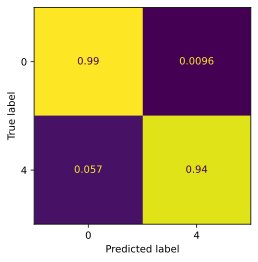

In [34]:
_ = ConfusionMatrixDisplay(confusion_matrix(ysD, y_predsD, labels=categories, normalize='true'), 
                       display_labels=categories).plot(colorbar=False)

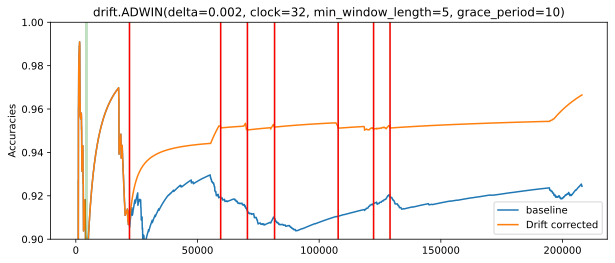

In [35]:
plot_acc(i_s, i_sD, accuracies, accuraciesD, dr_ADWIN, 'baseline', 'Drift corrected',
        'drift.ADWIN(delta=0.002, clock=32, min_window_length=5, grace_period=10)')

### DDM

In [36]:
modelD = deepcopy(Basemodel)

drd = drift.DDM(warm_start=100, warning_threshold=2.0, drift_threshold=3.0) #warm_start=30, warning_threshold=2.0, drift_threshold=3.0
dr_DDM = drift_reg()

i_sD, ysD, y_predsD, accuraciesD, report, ifiles, modelD = fit_modelD(data_df, flist, 'class', window_size, 
                                                                      modelD, dr_DDM, drd, dfB=False, EvalB=False)    

files learned  177 / 941
Warning detected at index 21354 121, ifile 176, label 0 0.0 WELL-00001_20170201020207
files learned  179 / 941
Warning detected at index 22028 196, ifile 178, label 0 0.0 WELL-00001_20170201120124

Change detected at index 22029 197, ifile 178, label 0 0.0 WELL-00001_20170201120124
*** model reinitializated ***
files learned  321 / 941
Warning detected at index 59500 107, ifile 320, label 0 0.0 WELL-00005_20170331160000

Change detected at index 59509 116, ifile 320, label 0 0.0 WELL-00005_20170331160000
*** model reinitializated ***
files learned  359 / 941
Warning detected at index 69879 145, ifile 358, label 0 0.0 WELL-00001_20170422040000

Change detected at index 69898 164, ifile 358, label 0 0.0 WELL-00001_20170422040000
*** model reinitializated ***
files learned  406 / 941
Warning detected at index 81401 157, ifile 405, label 0 0.0 WELL-00001_20170520190000

Change detected at index 81410 166, ifile 405, label 0 0.0 WELL-00001_20170520190000
*** model r

In [37]:
print('Number of drift points detected: {}'.format(dr_DDM.get_changes()))

Number of drift points detected: 13


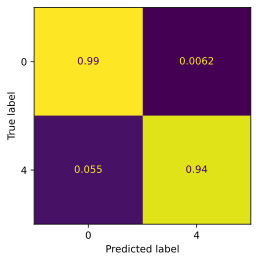

In [38]:
_ = ConfusionMatrixDisplay(confusion_matrix(ysD, y_predsD, labels=categories, normalize='true'), 
                       display_labels=categories).plot(colorbar=False)

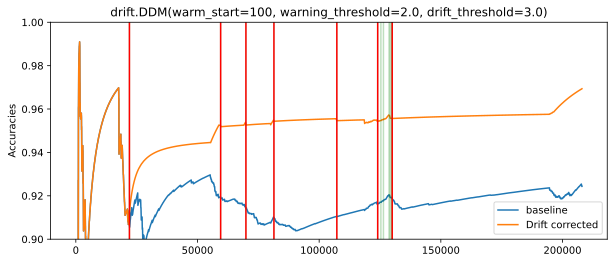

In [39]:
plot_acc(i_s, i_sD, accuracies, accuraciesD, dr_DDM, 'baseline', 'Drift corrected',
        'drift.DDM(warm_start=100, warning_threshold=2.0, drift_threshold=3.0)')

### EDDM

In [40]:
modelD = deepcopy(Basemodel)

drd = drift.EDDM(warm_start=30, alpha=0.95, beta=0.9) #warm_start=30, alpha=0.95, beta=0.9
dr_EDDM = drift_reg()

i_sD, ysD, y_predsD, accuraciesD, report, ifiles, modelD = fit_modelD(data_df, flist, 'class', window_size, 
                                                                      modelD, dr_EDDM, drd, dfB=False, EvalB=False)    

files learned  15 / 941
Change detected at index 1798 88, ifile 14, label 4 4.0 WELL-00002_20131212110000
files learned  20 / 941
Change detected at index 2396 83, ifile 19, label 4 4.0 WELL-00002_20131215000010
files learned  26 / 941
Warning detected at index 3075 36, ifile 25, label 4 4.0 WELL-00002_20131215120025

Change detected at index 3077 38, ifile 25, label 4 4.0 WELL-00002_20131215120025
files learned  33 / 941
Warning detected at index 3916 35, ifile 32, label 4 4.0 WELL-00002_20140109030025

Change detected at index 3920 39, ifile 32, label 4 4.0 WELL-00002_20140109030025

Change detected at index 3963 82, ifile 32, label 4 4.0 WELL-00002_20140109030025
files learned  34 / 941
Change detected at index 4056 54, ifile 33, label 4 4.0 WELL-00002_20140109050025
files learned  147 / 941
Change detected at index 17704 88, ifile 146, label 0 0.0 WELL-00004_20140806220033
*** model reinitializated ***
files learned  321 / 941
Change detected at index 59486 93, ifile 320, label 0 0

In [41]:
print('Number of drift points detected: {}'.format(dr_EDDM.get_changes()))

Number of drift points detected: 15


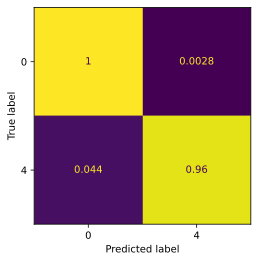

In [42]:
_ = ConfusionMatrixDisplay(confusion_matrix(ysD, y_predsD, labels=categories, normalize='true'), 
                       display_labels=categories).plot(colorbar=False)

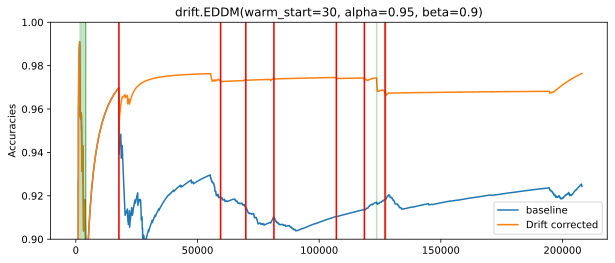

In [43]:
plot_acc(i_s, i_sD, accuracies, accuraciesD, dr_EDDM, 'baseline', 'Drift corrected',
        'drift.EDDM(warm_start=30, alpha=0.95, beta=0.9)')

### HDDM_A

In [44]:
modelD = deepcopy(Basemodel)

drd = drift.HDDM_A(drift_confidence=0.00005, warning_confidence=0.0001) # drift_confidence=0.001, warning_confidence=0.005
dr_HDDM_A = drift_reg()

i_sD, ysD, y_predsD, accuraciesD, report, ifiles, modelD = fit_modelD(data_df, flist, 'class', window_size, 
                                                                modelD, dr_HDDM_A, drd, dfB=False, EvalB=False)    

files learned  14 / 941
Warning detected at index 1624 34, ifile 13, label 4 4.0 WELL-00002_20131212090000

Change detected at index 1625 35, ifile 13, label 4 4.0 WELL-00002_20131212090000
files learned  15 / 941
Warning detected at index 1799 89, ifile 14, label 4 4.0 WELL-00002_20131212110000

Change detected at index 1800 90, ifile 14, label 4 4.0 WELL-00002_20131212110000
files learned  20 / 941
Warning detected at index 2392 79, ifile 19, label 4 4.0 WELL-00002_20131215000010

Change detected at index 2393 80, ifile 19, label 4 4.0 WELL-00002_20131215000010
files learned  24 / 941
Change detected at index 2871 74, ifile 23, label 4 4.0 WELL-00002_20131215080015
files learned  26 / 941
Warning detected at index 3073 34, ifile 25, label 4 4.0 WELL-00002_20131215120025

Change detected at index 3090 51, ifile 25, label 4 4.0 WELL-00002_20131215120025
files learned  32 / 941
Warning detected at index 3818 57, ifile 31, label 4 4.0 WELL-00002_20140109010112

Change detected at index 3

In [45]:
print('Number of drift points detected: {}'.format(dr_HDDM_A.get_changes()))

Number of drift points detected: 23


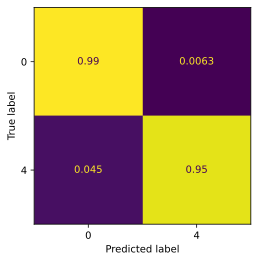

In [46]:
_ = ConfusionMatrixDisplay(confusion_matrix(ysD, y_predsD, labels=categories, normalize='true'), 
                       display_labels=categories).plot(colorbar=False)

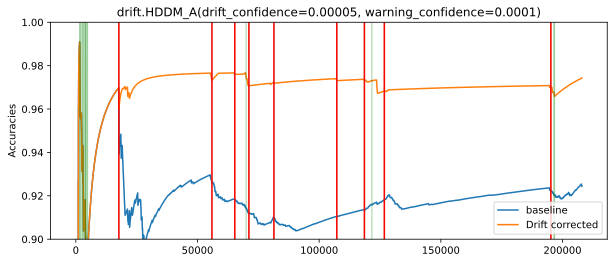

In [47]:
plot_acc(i_s, i_sD, accuracies, accuraciesD, dr_HDDM_A, 'baseline', 'Drift corrected',
        'drift.HDDM_A(drift_confidence=0.00005, warning_confidence=0.0001)')

### HDDM_W

In [48]:
modelD = deepcopy(Basemodel)

drd = drift.HDDM_W(drift_confidence=0.001, warning_confidence=0.005) # drift_confidence=0.001, warning_confidence=0.005
dr_HDDM = drift_reg()

i_sD, ysD, y_predsD, accuraciesD, report, ifiles, modelD = fit_modelD(data_df, flist, 'class', window_size, 
                                                            modelD, dr_HDDM, drd, dfB=False, EvalB=False)    

files learned  15 / 941
Warning detected at index 1800 90, ifile 14, label 4 4.0 WELL-00002_20131212110000
files learned  20 / 941
Warning detected at index 2394 81, ifile 19, label 4 4.0 WELL-00002_20131215000010

Change detected at index 2397 84, ifile 19, label 4 4.0 WELL-00002_20131215000010
files learned  34 / 941
Warning detected at index 4039 37, ifile 33, label 4 4.0 WELL-00002_20140109050025

Change detected at index 4043 41, ifile 33, label 4 4.0 WELL-00002_20140109050025
files learned  38 / 941
Warning detected at index 4564 78, ifile 37, label 4 4.0 WELL-00002_20140115180036

Change detected at index 4567 81, ifile 37, label 4 4.0 WELL-00002_20140115180036
files learned  40 / 941
Warning detected at index 4790 62, ifile 39, label 4 4.0 WELL-00002_20140119020020
files learned  147 / 941
Warning detected at index 17695 79, ifile 146, label 0 0.0 WELL-00004_20140806220033

Change detected at index 17698 82, ifile 146, label 0 0.0 WELL-00004_20140806220033
*** model reinitializ

In [49]:
print('Number of drift points detected: {}'.format(dr_HDDM.get_changes()))

Number of drift points detected: 11


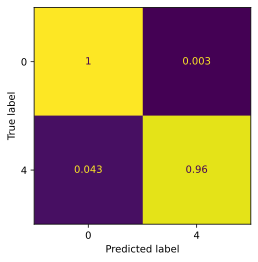

In [50]:
_ = ConfusionMatrixDisplay(confusion_matrix(ysD, y_predsD, labels=categories, normalize='true'), 
                       display_labels=categories).plot(colorbar=False)

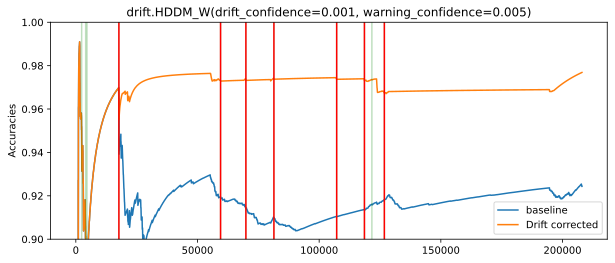

In [51]:
plot_acc(i_s, i_sD, accuracies, accuraciesD, dr_HDDM, 'baseline', 'Drift corrected',
        'drift.HDDM_W(drift_confidence=0.001, warning_confidence=0.005)')

### Comparación de detecciones de drift

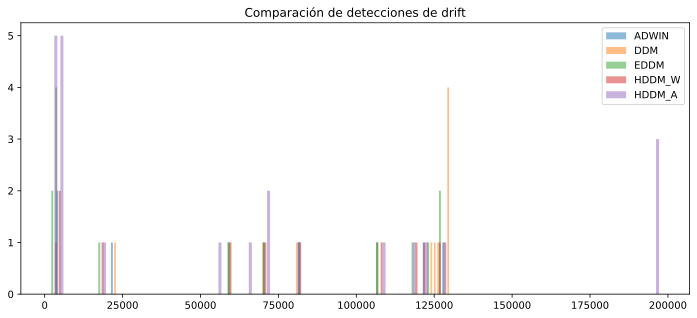

In [55]:
fig, ax = plt.subplots(figsize=(12,5))
n_bin = 100

res = dr_ADWIN.to_df()
ax.hist(res[res.change==True].i, bins=n_bin, alpha=0.5, rwidth=0.5, align='left', label='ADWIN')
res = dr_DDM.to_df()
ax.hist(res[res.change==True].i, bins=n_bin, alpha=0.5, rwidth=0.5, align='mid', label='DDM')
res = dr_EDDM.to_df()
ax.hist(res[res.change==True].i, bins=n_bin, alpha=0.5, rwidth=0.5, align='mid', label='EDDM')
res = dr_HDDM.to_df()
ax.hist(res[res.change==True].i, bins=n_bin, alpha=0.5, rwidth=0.5, align='right', label='HDDM_W')
res = dr_HDDM_A.to_df()
ax.hist(res[res.change==True].i, bins=n_bin, alpha=0.5, rwidth=0.5, align='right', label='HDDM_A')
ax.legend()
ax.set_title('Comparación de detecciones de drift')
plt.show()

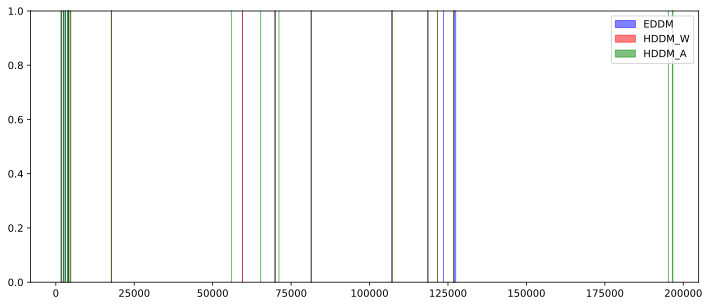

In [53]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(12,5))

res = dr_EDDM.to_df()
for i in res[res.change==True].i:
    ax.axvline(x=i, c='blue', alpha=0.75, linewidth=0.75)
res = dr_HDDM.to_df()
for i in res[res.change==True].i:
    ax.axvline(x=i, c='red', alpha=0.75, linewidth=0.75)
res = dr_HDDM_A.to_df()
for i in res[res.change==True].i:
    ax.axvline(x=i, c='green', alpha=0.75, linewidth=0.75)

red_patch = mpatches.Patch(color='red', alpha=0.5, label='HDDM_W')
blue_patch = mpatches.Patch(color='blue', alpha=0.5, label='EDDM')
green_patch = mpatches.Patch(color='green', alpha=0.5, label='HDDM_A')
ax.legend(handles=[blue_patch, red_patch, green_patch], loc='upper right')
    
plt.show()